In [28]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
from transformers import CLIPModel, CLIPProcessor
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import glob
import os 
from PIL import Image
import cv2
import torch.nn.functional as F
import torch.nn as nn 
from torchvision.models import resnet50, ResNet50_Weights
import torch.optim as optim
import tqdm

import matplotlib.cm as cm 


In [2]:
def set_seed(seed:int = 42)-> None:
    """Seed is being set for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42) # Setting the seed so that whenever we try to run the notebook again we get the same results.

In [3]:
class config:
    """Class to set up the configuration parameters"""
    def __init__(self)-> None:
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # Defining the paths to the directories
        self.train_image_dir = "/home/moonlab/Reid/data/VeRi/image_train"
        self.query__image__dir = "/home/moonlab/Reid/data/VeRi/image_query"
        self.gallery__image__dir = "/home/moonlab/Reid/data/VeRi/image_test"

        # Defining the Model Settings 
        self.clip_model_name="openai/clip-vit-base-patch32"
        self.image_size=(256,256)

        # Defining the Model Parameters
        self.batch_size=32
        self.num_workers=4
        self.learning_rate=1e-4
        self.epochs=60
        

        # Defining the dimensions
        self.num_classes=576
        self.feat_dim=2048
        self.clip_dim=512



cfg=config()
cfg.device


        

## Till now we have successfully set up the configuration and seeds.

'cuda'

(np.float64(-0.5), np.float64(410.5), np.float64(298.5), np.float64(-0.5))

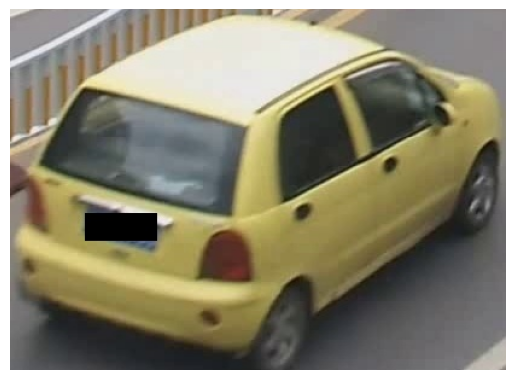

In [4]:
## lets visualize some images from the dataset
image_path1="/home/moonlab/Reid/data/VeRi/image_query/0002_c002_00030600_0.jpg"
image=cv2.imread(image_path1)
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.axis("off")



In [5]:
class CarlaVeriDataset(Dataset):
    """This class inherits from the Dataset class of pytorch, hence we will define 
        The required 3 methods __init_, __len__ and __getitem__"""


    """
         Custom class for loading the Veri Dataset. 
         This class handles the infamous Veri-776 dataset having the 776 classes.
         This function takes the paths of the image as the input and converts them into useful lists like the vehcile id and the camera id.
       
    """
    
    def __init__(self, dir_path:str, transform=None)->None:
        self.dir_path=dir_path
        self.transform=transform

        # get all the image_paths
        self.image_path=glob.glob(os.path.join(self.dir_path, "*.jpg"))
        self.image_path=sorted(self.image_path)

        if self.image_path is None:
            print("There are no images in the directory.")

        self.pids=[] # This is there to store the vehicle ids
        self.camids=[] # This is there to store the camera ids
        self.valid_paths=[]

        for paths in self.image_path:
            filename=os.path.basename(paths).replace(".jpg","")
            parts=filename.split("_")

            if len(paths)>=2:
                pid=int(parts[0])
                if parts[1].startswith('c'):
                    camid=int(parts[1][1:])
                else:
                    camid=int(parts[1])

                self.pids.append(pid)
                self.camids.append(camid)
                self.valid_paths.append(paths)
        self.image_path=self.valid_paths

        """Note: The PIDS that we have here are not continuous so we have to make sure that they are continous value 
        starting from 0 to num_classes-1, Otherwise our model will collapse during training"""

        self.unique_pids=sorted(list(set(self.pids)))
        self.pid_maps={old:new for new,old in enumerate(self.unique_pids)}
        self.new_pids=[self.pid_maps[p] for p in self.pids]

        print(f"Total images: {len(self.image_path)} Total unique pids: {len(self.unique_pids)}")
        
        
    def __len__(self)-> int:
        return len(self.image_path)
    
    def __getitem__(self, index:int)-> tuple:
        """ This fnction fetches you the image and the corresponding labels"""
        path=self.image_path[index]
        camid=self.camids[index]
        pid=self.new_pids[index]
        original_pid=self.pids[index]

        image=cv2.imread(path)
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image=Image.fromarray(image)
        if self.transform is not None:
            image=self.transform(image)

        return image, pid, camid,original_pid,path
            

        



In [6]:
## lets define the transforms for the dataset
train_transforms=T.Compose([
    T.Resize((256,256)),
    T.RandomHorizontalFlip(),
    T.Pad(10),
    T.RandomCrop(256,256),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

## lets execute the verification on the train dataset
train_directory=cfg.train_image_dir
train_dataset=CarlaVeriDataset(dir_path=train_directory, transform=train_transforms)

Total images: 37778 Total unique pids: 576


In [7]:
train_dataset[0]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [8]:
class IBN(nn.Module):
    """
    This class implements the Instance-Batch Normalization Layer. 
    NOTE:" Why Instance-Batch Normalization Layer?
    The ResNet that we are implementing here is not the standard ResNet,
    But a modified ResNet with IBN layers.

    Standard ResNet uses Batch Normalization that normalizes the features across the entire batch.
    Instance Normalization normalizes the features for each instance in the batch seperately.


    IN IBN, the feature channels are split into two parts: one part undersgoes Instance Normalization, while the other part goes to the Batch Normalization.
    """

    def __init__(self,planes:int)-> None:
        """In this class we pass the number of feature planes as input"""
        super(IBN,self).__init__()
        half1=int(planes/2)
        half2=planes-half1

        self.IN =nn.InstanceNorm2d(half1,affine=True)
        self.BN=nn.BatchNorm2d(half2)


            
    def forward(self,x:torch.Tensor)-> torch.Tensor:
        """This function defines the forward pass of the IBN Layer"""
        split_size = x.size(1) // 2
        split=torch.split(x, split_size,1)

        out1=self.IN(split[0].contiguous())
        out2=self.BN(split[1].contiguous())


        out=torch.cat((out1,out2),1)
        return out


In [9]:
ibn=IBN(256)
ibn

IBN(
  (IN): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (BN): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [10]:
class BottleneckIBN(nn.Module):
    """This class defines how or convolution layers should be looking but including the Instance Batch Normalization BottleNeck"""
    expansion=4
    def __init__(self, inplanes, planes, strides=1, downsample=None):
        super(BottleneckIBN,self).__init__()

        self.conv1=nn.Conv2d(in_channels=inplanes,out_channels=planes,kernel_size=1,bias=False)
        self.bn1=IBN(planes)

        self.conv2=nn.Conv2d(in_channels=planes, out_channels=planes, padding=1, kernel_size=3, stride=strides, bias=False)
        self.bn2=nn.BatchNorm2d(planes)

        self.conv3=nn.Conv2d(in_channels=planes, out_channels=planes*self.expansion,kernel_size=1, bias=False)
        self.bn3=nn.BatchNorm2d(planes*self.expansion)

        self.relu=nn.ReLU(inplace=True)

        self.downsample=downsample
        self.strides=strides


    def forward(self,x: torch.Tensor)-> torch.Tensor:
        identity=x
        out=self.conv1(x)
        out=self.bn1(out)
        out=self.relu(out)

        out=self.conv2(out)
        out=self.bn2(out)
        out=self.relu(out)

        out=self.conv3(out)
        out=self.bn3(out)

        if self.downsample is not None:
            identity=self.downsample(x)

        out+=identity
        out=self.relu(out)

        return out

        

    


In [11]:
class ResNetIBN(torch.nn.Module):
    """In this module we will define the ResNet50 architecture as the feature extractor"""
    def __init__(self,config):
        super(ResNetIBN,self).__init__()
        self.model=resnet50(weights=ResNet50_Weights.DEFAULT)
        layer1_layers=[]

        layer1_layers.append(BottleneckIBN(64,64,strides=1,downsample=self.model.layer1[0].downsample))
        layer1_layers.append(BottleneckIBN(256,64,strides=1))
        layer1_layers.append(BottleneckIBN(256,64,strides=1))


        self.model.layer1=nn.Sequential(*layer1_layers)
        self.model.avgpool=nn.AdaptiveAvgPool2d((1,1))
        self.model.fc=nn.Identity()

        self.model.out_dim=2048


    def forward(self,x):
        features=self.model(x)
        return features
        

        


In [12]:
class SemanticExtractionModule(nn.Module):
    """
    This class defines the semantic extraction module  using the ClipVector
    Here we input the image tensor and get the CLS token as the semantic vector representation of the image.
    Here the pooler output that we are taking is the CLS token representation of the image. 
    """
    def __init__(self,config):
        super(SemanticExtractionModule,self).__init__()
        self.clip=CLIPModel.from_pretrained(config.clip_model_name)

        self.vision_model = self.clip.vision_model
        
        # 2. The Projection Layer (Maps 768 -> 512 dim)
        self.visual_projection = self.clip.visual_projection
        
        # Freeze everything to save memory/compute
        for param in self.vision_model.parameters():
            param.requires_grad = False
        for param in self.visual_projection.parameters():
            param.requires_grad = False
        self.output_dim=config.clip_dim


    def forward(self,x:torch.Tensor)-> torch.Tensor:
        vision_outputs=self.vision_model(pixel_values=x,interpolate_pos_encoding=True)
        semantic_features=vision_outputs.pooler_output
        semantic_features = self.visual_projection(semantic_features)

        return semantic_features

In [13]:
class FusionModule(nn.Module):
    """This class is the fusion module that fuses the features that we get from the ResNetIBN and the semantic extraction module"""
    def __init__(self,config):
        super(FusionModule,self).__init__()

        self.feat_dim=config.feat_dim
        self.clip_dim=config.clip_dim


        self.dim_reduce=nn.Sequential(
            nn.Linear(in_features=self.feat_dim+self.clip_dim,out_features=self.feat_dim,bias=False),
            nn.BatchNorm1d(self.feat_dim),
            nn.ReLU(inplace=True))
        


    def forward(self, visual_features:torch.Tensor, semantic_features:torch.Tensor)-> torch.Tensor:
        f1=visual_features.view(visual_features.size(0),-1)
        f2=semantic_features.view(semantic_features.size(0),-1)

        fused_features=torch.cat((f1,f2),dim=1)
        fused_features=self.dim_reduce(fused_features)
        return fused_features
        
        

In [14]:
class AFEMModule(torch.nn.Module):
    """
    This class defines the Adaptive Feature Enhancement Module as discussed in the paper 

    """

    def __init__(self, in_dim,out_dim, groups):
        super(AFEMModule,self).__init__()

        self.groups=groups
        self.in_dim=in_dim

        self.f_linear=nn.Sequential(
            nn.Linear(in_dim,out_dim),
            nn.BatchNorm1d(out_dim),
            nn.ReLU(inplace=True)
        )

        """
        The 512 dimensional feature vector that we got from the clip image encoding we are passing it that to the semantic feature enhancement module module.
        where the vectors are first past through a linear MLP, Batch Normalization and ReLU activation function.
        Then since we have decided that the number of groups that we have is 32 so based on the semantic vector dimension we will divide the semantic vector into the respective groups and

        """

        ## Lets define the parameter weights

        self.W = nn.Parameter(torch.tensor(torch.zeros(1, groups) + 1e-3))


    def forward(self,t_s):
        x=self.f_linear(t_s)

        batch,dim=x.shape
        channels_per_group= dim//self.groups
        """Here we are dividing the the features into groups"""

        x_grouped=x.view(batch,self.groups,channels_per_group)
        expanded_weights=self.W.view(1, self.groups, 1)
        weighted_groups=x_grouped*expanded_weights

        weighted_out=weighted_groups.view(batch,dim)

        ts_prime=x+weighted_out

        return ts_prime

        

In [15]:
class CLIP_SENet(nn.Module):
    """This class is defined so that  whatever we have build till now we can use that up."""
    
    def __init__(self,config)->None:
        super(CLIP_SENet,self).__init__()

        # Lets call the apprearence backbone
        self.backbone=ResNetIBN(config)
        self.gap=nn.AdaptiveAvgPool2d(1)

        # Lets call the semantic module

        self.sem_module=SemanticExtractionModule(config)
        self.sem_bn=nn.BatchNorm1d(config.clip_dim)

        self.afem=AFEMModule(in_dim=config.clip_dim, out_dim=config.feat_dim,groups=32)

        self.fusion_module=FusionModule(config=config)

        self.bottleneck=nn.BatchNorm1d(config.feat_dim)
        self.classifier=nn.Linear(in_features=config.feat_dim, out_features=cfg.num_classes,bias=False)

        self.identity_loss=nn.CrossEntropyLoss()
        self.trip_loss=nn.TripletMarginLoss(margin=0.3)


    def forward(self,images:torch.tensor,labels):
        """Here the input is the iamge of B,C,H,W and the batch of the ground truth of the labels """
        ta=self.backbone(images)
        ts=self.sem_module(images)
        ts=self.sem_bn(ts)

        ts_prime=self.afem(ts)

        fusion=self.fusion_module(ta,ts)

        t=ts_prime + fusion

        feat_norm=self.bottleneck(t)
        logits=self.classifier(t)

        


        return t,logits



        



In [16]:
class LossWrapper(nn.Module):
    def __init__(self,num_classes,epsilon=0.1, temperature=0.07):
        super(LossWrapper,self).__init__()

        self.ce_loss=nn.CrossEntropyLoss(label_smoothing=epsilon)
        self.temperature=temperature


    def supercon_loss(self,features,labels):
        """In the supercontrastive loss we push the positive and negative pairs apart and pull close the positive pair"""
        device=cfg.device
        batch_size=features.shape[0]

        features= F.normalize(features,dim=1)

        similarity_matrix=torch.matmul(features,features.T)

        labels=labels.contiguous().view(-1,1)
        mask=torch.eq(labels,labels.T).float().to(device)
        logit_masks=torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size).view(-1,1).to(device),
            0
        )
        mask=mask*logit_masks
        logits=similarity_matrix / self.temperature

        logits_max,_=torch.max(logits,dim=1,keepdim=True)
        logits=logits-logits_max.detach()


        exp_logits=torch.exp(logits)*logit_masks
        log_prob=logits-torch.log(exp_logits.sum(1,keepdim=True)+1e-12)

        mask_pos_pairs = mask.sum(1)
        
        # Avoid division by zero: 
        # If an anchor has no positives, set divisor to 1 (loss becomes 0 for that sample)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, torch.ones_like(mask_pos_pairs), mask_pos_pairs)

        mean_log_prob_pos=(mask*log_prob).sum(1) / mask_pos_pairs
        loss=-mean_log_prob_pos.mean()


        return loss
    
    def forward(self,cls_score,features,targets):
        ce_loss=self.ce_loss(cls_score,targets)
        sc_loss=self.supercon_loss(features,targets)
        total_loss= ce_loss+sc_loss

        return total_loss,ce_loss,sc_loss
    

    



        
    

In [17]:
import tqdm
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader

def train():
    # --- 1. TRANSFORMS & DATA ---
    train_transforms = T.Compose([
        T.Resize((256, 256)),
        T.RandomHorizontalFlip(),
        T.Pad(10),
        T.RandomCrop(256, 256),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    print("Transformations done! Loading the data .....")

    train_dataset = CarlaVeriDataset(dir_path=cfg.train_image_dir, transform=train_transforms)
    cfg.num_classes = len(train_dataset.unique_pids)
    
    # Note: Ideally, switch shuffle=True to the RandomIdentitySampler discussed earlier for better SC loss
    train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers)

    print("Dataset Loaded! Initializing the Model")
    model = CLIP_SENet(cfg).to(cfg.device)
    criterion = LossWrapper(num_classes=cfg.num_classes).to(cfg.device)

    # --- 2. GRADIENT CHECK ---
    print("Model Initialization done! Doing the Gradients Safety Check")
    trainable_params = 0
    frozen_params = 0

    print(f" {'Module':<25} | {'Status':<10} | {'Params'}")
    print("-" * 50)

    for name, param in model.named_parameters():
        if param.requires_grad:
            trainable_params += param.numel()
        else:
            frozen_params += param.numel()

    print("-" * 50)
    print(f"Trainable Params: {trainable_params}")
    print(f"Frozen Params: {frozen_params}")

    if frozen_params == 0:
        print(" Warning! The clip encoder is not frozen ... Recheck the Clip Module")
    else:
        print("Success")

    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate, weight_decay=5e-4)

    # --- 3. TRAINING LOOP ---
    print("\nStarting Training...")
    model.train()

    # Enable Anomaly Detection (Optional: Disable this later for speed if stable)
    torch.autograd.set_detect_anomaly(True)

    for epoch in range(cfg.epochs):
        # Initialize accumulators for the epoch
        total_loss = 0.0
        total_ce = 0.0
        total_sc = 0.0
        num_batches = 0
        
        loop = tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{cfg.epochs}")
        
        for images, labels, camids, original_pids, paths in loop:
            images = images.to(cfg.device)
            labels = labels.to(cfg.device)

            optimizer.zero_grad()

            # Forward Pass
            features, logits = model(images, labels)
            
            # NaN Check
            if torch.isnan(features).any():
                print("NaN detected in Features! Skipping Batch.")
                continue

            # Loss Calculation
            loss, ce, sc = criterion(logits, features, labels)

            # Backward Pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
            optimizer.step()
            
            # Accumulate metrics
            total_loss += loss.item()
            total_ce += ce.item()
            total_sc += sc.item()
            num_batches += 1
            
            # Update Progress Bar (shows current batch loss)
            loop.set_postfix(loss=loss.item(), ce=ce.item(), sc=sc.item())

        # --- END OF EPOCH STATS ---
        # Calculate averages
        avg_loss = total_loss / num_batches if num_batches > 0 else 0
        avg_ce = total_ce / num_batches if num_batches > 0 else 0
        avg_sc = total_sc / num_batches if num_batches > 0 else 0
        
        # Print clearly
        print(f"\nEpoch [{epoch+1}/{cfg.epochs}] Summary:")
        print(f"  Avg Total Loss: {avg_loss:.4f}")
        print(f"  Avg CE Loss:    {avg_ce:.4f}")
        print(f"  Avg SC Loss:    {avg_sc:.4f}")
        print("-" * 30)
        
        # Save Checkpoint
        torch.save(model.state_dict(), "latest_model.pth")

if __name__ == "__main__":
    train()

Transformations done! Loading the data .....
Total images: 37778 Total unique pids: 576
Dataset Loaded! Initializing the Model


/tmp/ipykernel_3626/274845811.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.W = nn.Parameter(torch.tensor(torch.zeros(1, groups) + 1e-3))


Model Initialization done! Doing the Gradients Safety Check
 Module                    | Status     | Params
--------------------------------------------------
--------------------------------------------------
Trainable Params: 94422625
Frozen Params: 87849216
Success

Starting Training...


Epoch 1/60: 100%|██████████| 1181/1181 [05:34<00:00,  3.53it/s, ce=4.94, loss=4.94, sc=-0]    



Epoch [1/60] Summary:
  Avg Total Loss: 5.9820
  Avg CE Loss:    5.7217
  Avg SC Loss:    0.2603
------------------------------


Epoch 2/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=5.05, loss=5.27, sc=0.221] 



Epoch [2/60] Summary:
  Avg Total Loss: 5.3142
  Avg CE Loss:    5.0681
  Avg SC Loss:    0.2461
------------------------------


Epoch 3/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=4.77, loss=4.95, sc=0.171] 



Epoch [3/60] Summary:
  Avg Total Loss: 4.9996
  Avg CE Loss:    4.7642
  Avg SC Loss:    0.2355
------------------------------


Epoch 4/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=4.92, loss=4.92, sc=-0]    



Epoch [4/60] Summary:
  Avg Total Loss: 4.7965
  Avg CE Loss:    4.5558
  Avg SC Loss:    0.2407
------------------------------


Epoch 5/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=4.48, loss=4.48, sc=-0]    



Epoch [5/60] Summary:
  Avg Total Loss: 4.6029
  Avg CE Loss:    4.3795
  Avg SC Loss:    0.2234
------------------------------


Epoch 6/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=4.22, loss=4.22, sc=-0]    



Epoch [6/60] Summary:
  Avg Total Loss: 4.4780
  Avg CE Loss:    4.2521
  Avg SC Loss:    0.2258
------------------------------


Epoch 7/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=3.93, loss=3.93, sc=-0]     



Epoch [7/60] Summary:
  Avg Total Loss: 4.3770
  Avg CE Loss:    4.1529
  Avg SC Loss:    0.2241
------------------------------


Epoch 8/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=4.9, loss=4.9, sc=-0]       



Epoch [8/60] Summary:
  Avg Total Loss: 4.2817
  Avg CE Loss:    4.0581
  Avg SC Loss:    0.2236
------------------------------


Epoch 9/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=3.99, loss=3.99, sc=-0]    



Epoch [9/60] Summary:
  Avg Total Loss: 4.1971
  Avg CE Loss:    3.9838
  Avg SC Loss:    0.2133
------------------------------


Epoch 10/60: 100%|██████████| 1181/1181 [05:17<00:00,  3.71it/s, ce=4.57, loss=4.57, sc=-0]    



Epoch [10/60] Summary:
  Avg Total Loss: 4.1430
  Avg CE Loss:    3.9201
  Avg SC Loss:    0.2229
------------------------------


Epoch 11/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=4.03, loss=4.03, sc=-0]    



Epoch [11/60] Summary:
  Avg Total Loss: 4.0705
  Avg CE Loss:    3.8607
  Avg SC Loss:    0.2098
------------------------------


Epoch 12/60: 100%|██████████| 1181/1181 [05:17<00:00,  3.71it/s, ce=3.79, loss=4.03, sc=0.236] 



Epoch [12/60] Summary:
  Avg Total Loss: 4.0325
  Avg CE Loss:    3.8238
  Avg SC Loss:    0.2087
------------------------------


Epoch 13/60: 100%|██████████| 1181/1181 [05:19<00:00,  3.70it/s, ce=3.65, loss=3.65, sc=-0]    



Epoch [13/60] Summary:
  Avg Total Loss: 3.9792
  Avg CE Loss:    3.7719
  Avg SC Loss:    0.2073
------------------------------


Epoch 14/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=3.41, loss=3.41, sc=-0]     



Epoch [14/60] Summary:
  Avg Total Loss: 3.9462
  Avg CE Loss:    3.7301
  Avg SC Loss:    0.2161
------------------------------


Epoch 15/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=3.21, loss=3.21, sc=-0]    



Epoch [15/60] Summary:
  Avg Total Loss: 3.9189
  Avg CE Loss:    3.7077
  Avg SC Loss:    0.2112
------------------------------


Epoch 16/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=3.82, loss=3.82, sc=-0]    



Epoch [16/60] Summary:
  Avg Total Loss: 3.8828
  Avg CE Loss:    3.6659
  Avg SC Loss:    0.2169
------------------------------


Epoch 17/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=3.56, loss=3.56, sc=-0]     



Epoch [17/60] Summary:
  Avg Total Loss: 3.8327
  Avg CE Loss:    3.6249
  Avg SC Loss:    0.2078
------------------------------


Epoch 18/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=3.04, loss=3.04, sc=-0]    



Epoch [18/60] Summary:
  Avg Total Loss: 3.8213
  Avg CE Loss:    3.6122
  Avg SC Loss:    0.2091
------------------------------


Epoch 19/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=3.96, loss=3.96, sc=-0]    



Epoch [19/60] Summary:
  Avg Total Loss: 3.7984
  Avg CE Loss:    3.5886
  Avg SC Loss:    0.2098
------------------------------


Epoch 20/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=3.39, loss=3.56, sc=0.167] 



Epoch [20/60] Summary:
  Avg Total Loss: 3.7533
  Avg CE Loss:    3.5428
  Avg SC Loss:    0.2106
------------------------------


Epoch 21/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=3.75, loss=3.75, sc=-0]    



Epoch [21/60] Summary:
  Avg Total Loss: 3.7481
  Avg CE Loss:    3.5366
  Avg SC Loss:    0.2115
------------------------------


Epoch 22/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=3.43, loss=3.65, sc=0.218]  



Epoch [22/60] Summary:
  Avg Total Loss: 3.7130
  Avg CE Loss:    3.5174
  Avg SC Loss:    0.1956
------------------------------


Epoch 23/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=3.48, loss=3.48, sc=-0]     



Epoch [23/60] Summary:
  Avg Total Loss: 3.7168
  Avg CE Loss:    3.5115
  Avg SC Loss:    0.2053
------------------------------


Epoch 24/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=3.46, loss=3.46, sc=-0]     



Epoch [24/60] Summary:
  Avg Total Loss: 3.7301
  Avg CE Loss:    3.5204
  Avg SC Loss:    0.2098
------------------------------


Epoch 25/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=4.06, loss=4.06, sc=-0]     



Epoch [25/60] Summary:
  Avg Total Loss: 3.6785
  Avg CE Loss:    3.4780
  Avg SC Loss:    0.2005
------------------------------


Epoch 26/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=4.11, loss=4.11, sc=-0]     



Epoch [26/60] Summary:
  Avg Total Loss: 3.6818
  Avg CE Loss:    3.4766
  Avg SC Loss:    0.2052
------------------------------


Epoch 27/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=3.57, loss=3.94, sc=0.368] 



Epoch [27/60] Summary:
  Avg Total Loss: 3.6523
  Avg CE Loss:    3.4417
  Avg SC Loss:    0.2105
------------------------------


Epoch 28/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=3.17, loss=3.17, sc=-0]    



Epoch [28/60] Summary:
  Avg Total Loss: 3.6605
  Avg CE Loss:    3.4487
  Avg SC Loss:    0.2118
------------------------------


Epoch 29/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=3.91, loss=4.26, sc=0.349] 



Epoch [29/60] Summary:
  Avg Total Loss: 3.6494
  Avg CE Loss:    3.4393
  Avg SC Loss:    0.2101
------------------------------


Epoch 30/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=2.63, loss=2.73, sc=0.1]   



Epoch [30/60] Summary:
  Avg Total Loss: 3.6049
  Avg CE Loss:    3.4135
  Avg SC Loss:    0.1914
------------------------------


Epoch 31/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=2.78, loss=2.78, sc=-0]     



Epoch [31/60] Summary:
  Avg Total Loss: 3.5997
  Avg CE Loss:    3.4030
  Avg SC Loss:    0.1967
------------------------------


Epoch 32/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=3.75, loss=3.75, sc=-0]     



Epoch [32/60] Summary:
  Avg Total Loss: 3.5850
  Avg CE Loss:    3.3866
  Avg SC Loss:    0.1984
------------------------------


Epoch 33/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=3.11, loss=3.11, sc=-0]    



Epoch [33/60] Summary:
  Avg Total Loss: 3.5950
  Avg CE Loss:    3.3981
  Avg SC Loss:    0.1970
------------------------------


Epoch 34/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=3.26, loss=3.26, sc=-0]     



Epoch [34/60] Summary:
  Avg Total Loss: 3.5622
  Avg CE Loss:    3.3707
  Avg SC Loss:    0.1915
------------------------------


Epoch 35/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=2.89, loss=3.19, sc=0.308]  



Epoch [35/60] Summary:
  Avg Total Loss: 3.5528
  Avg CE Loss:    3.3647
  Avg SC Loss:    0.1881
------------------------------


Epoch 36/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=2.99, loss=2.99, sc=-0]     



Epoch [36/60] Summary:
  Avg Total Loss: 3.5612
  Avg CE Loss:    3.3632
  Avg SC Loss:    0.1980
------------------------------


Epoch 37/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=3.24, loss=3.24, sc=-0]    



Epoch [37/60] Summary:
  Avg Total Loss: 3.5488
  Avg CE Loss:    3.3485
  Avg SC Loss:    0.2003
------------------------------


Epoch 38/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=3.05, loss=3.05, sc=-0]     



Epoch [38/60] Summary:
  Avg Total Loss: 3.5375
  Avg CE Loss:    3.3464
  Avg SC Loss:    0.1911
------------------------------


Epoch 39/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=2.29, loss=2.29, sc=-0]     



Epoch [39/60] Summary:
  Avg Total Loss: 3.5288
  Avg CE Loss:    3.3346
  Avg SC Loss:    0.1942
------------------------------


Epoch 40/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=3.86, loss=3.86, sc=-0]     



Epoch [40/60] Summary:
  Avg Total Loss: 3.5185
  Avg CE Loss:    3.3268
  Avg SC Loss:    0.1917
------------------------------


Epoch 41/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=2.54, loss=2.66, sc=0.128]  



Epoch [41/60] Summary:
  Avg Total Loss: 3.5188
  Avg CE Loss:    3.3147
  Avg SC Loss:    0.2040
------------------------------


Epoch 42/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=2.93, loss=3.09, sc=0.164]  



Epoch [42/60] Summary:
  Avg Total Loss: 3.4991
  Avg CE Loss:    3.3035
  Avg SC Loss:    0.1957
------------------------------


Epoch 43/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=3.13, loss=3.13, sc=-0]    



Epoch [43/60] Summary:
  Avg Total Loss: 3.4900
  Avg CE Loss:    3.2941
  Avg SC Loss:    0.1959
------------------------------


Epoch 44/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=3.17, loss=3.33, sc=0.153]  



Epoch [44/60] Summary:
  Avg Total Loss: 3.4840
  Avg CE Loss:    3.2968
  Avg SC Loss:    0.1872
------------------------------


Epoch 45/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=3.51, loss=3.62, sc=0.106]  



Epoch [45/60] Summary:
  Avg Total Loss: 3.4742
  Avg CE Loss:    3.2798
  Avg SC Loss:    0.1944
------------------------------


Epoch 46/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=3.83, loss=3.83, sc=-0]     



Epoch [46/60] Summary:
  Avg Total Loss: 3.4956
  Avg CE Loss:    3.2909
  Avg SC Loss:    0.2047
------------------------------


Epoch 47/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=2.68, loss=2.68, sc=-0]     



Epoch [47/60] Summary:
  Avg Total Loss: 3.4454
  Avg CE Loss:    3.2551
  Avg SC Loss:    0.1903
------------------------------


Epoch 48/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=4.01, loss=4.54, sc=0.527]  



Epoch [48/60] Summary:
  Avg Total Loss: 3.4630
  Avg CE Loss:    3.2783
  Avg SC Loss:    0.1846
------------------------------


Epoch 49/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=4.61, loss=4.61, sc=-0]     



Epoch [49/60] Summary:
  Avg Total Loss: 3.4410
  Avg CE Loss:    3.2472
  Avg SC Loss:    0.1938
------------------------------


Epoch 50/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=3.58, loss=3.58, sc=-0]     



Epoch [50/60] Summary:
  Avg Total Loss: 3.4333
  Avg CE Loss:    3.2436
  Avg SC Loss:    0.1897
------------------------------


Epoch 51/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=2.97, loss=2.97, sc=-0]    



Epoch [51/60] Summary:
  Avg Total Loss: 3.4414
  Avg CE Loss:    3.2478
  Avg SC Loss:    0.1936
------------------------------


Epoch 52/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=2.96, loss=2.96, sc=-0]     



Epoch [52/60] Summary:
  Avg Total Loss: 3.4109
  Avg CE Loss:    3.2259
  Avg SC Loss:    0.1850
------------------------------


Epoch 53/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=2.95, loss=3.2, sc=0.25]    



Epoch [53/60] Summary:
  Avg Total Loss: 3.4499
  Avg CE Loss:    3.2526
  Avg SC Loss:    0.1974
------------------------------


Epoch 54/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=3.45, loss=3.5, sc=0.0494]  



Epoch [54/60] Summary:
  Avg Total Loss: 3.4223
  Avg CE Loss:    3.2267
  Avg SC Loss:    0.1956
------------------------------


Epoch 55/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=3.14, loss=3.14, sc=-0]     



Epoch [55/60] Summary:
  Avg Total Loss: 3.4028
  Avg CE Loss:    3.2218
  Avg SC Loss:    0.1810
------------------------------


Epoch 56/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=2.51, loss=2.59, sc=0.0731]



Epoch [56/60] Summary:
  Avg Total Loss: 3.4024
  Avg CE Loss:    3.2128
  Avg SC Loss:    0.1896
------------------------------


Epoch 57/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=3.5, loss=3.61, sc=0.105]   



Epoch [57/60] Summary:
  Avg Total Loss: 3.3854
  Avg CE Loss:    3.1963
  Avg SC Loss:    0.1892
------------------------------


Epoch 58/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=3.39, loss=3.81, sc=0.416]  



Epoch [58/60] Summary:
  Avg Total Loss: 3.3846
  Avg CE Loss:    3.1975
  Avg SC Loss:    0.1870
------------------------------


Epoch 59/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=3, loss=3, sc=-0]           



Epoch [59/60] Summary:
  Avg Total Loss: 3.4036
  Avg CE Loss:    3.2143
  Avg SC Loss:    0.1893
------------------------------


Epoch 60/60: 100%|██████████| 1181/1181 [05:18<00:00,  3.71it/s, ce=3.32, loss=3.32, sc=-0]     



Epoch [60/60] Summary:
  Avg Total Loss: 3.3646
  Avg CE Loss:    3.1815
  Avg SC Loss:    0.1831
------------------------------


Loading weights from: latest_model.pth


'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /openai/clip-vit-base-patch32/resolve/main/config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno -3] Temporary failure in name resolution)"))'), '(Request ID: 6bb29c58-a6d0-41f8-96e7-aeced0f83784)')' thrown while requesting HEAD https://huggingface.co/openai/clip-vit-base-patch32/resolve/main/config.json
Retrying in 1s [Retry 1/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /openai/clip-vit-base-patch32/resolve/main/config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno -3] Temporary failure in name resolution)"))'), '(Request ID: 49b84df4-a833-4461-a604-4aefd1adbc25)')' thrown while requesting HEAD https://huggingface.co/openai/clip-vit-base-patch32/res

Processing Query: 0776_c009_00000000_0.jpg
Scanning gallery...


100%|██████████| 11579/11579 [01:35<00:00, 121.82it/s]


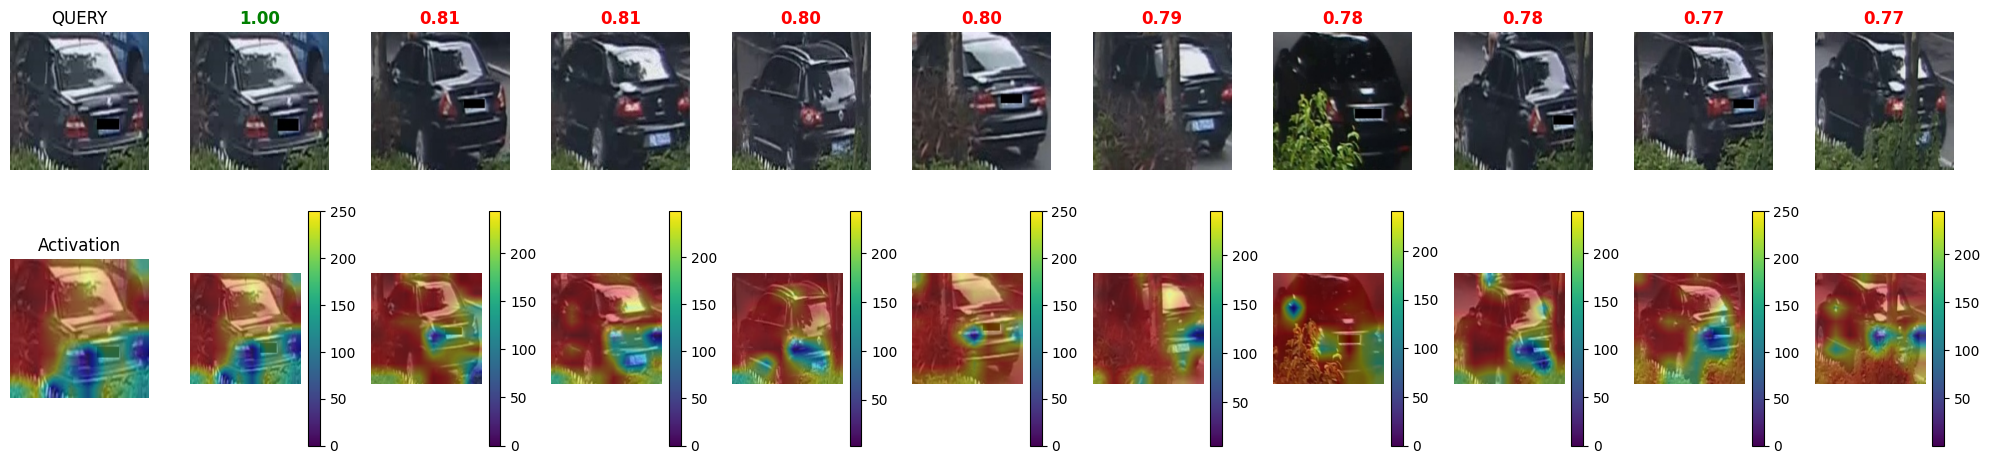

In [21]:
inference_transforms = T.Compose([
    T.Resize(cfg.image_size),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


def load_trained_model(weights_path):
    print(f"Loading weights from: {weights_path}")
    state_dict = torch.load(weights_path, map_location=cfg.device)
    
    
    if 'classifier.weight' in state_dict:
        trained_classes = state_dict['classifier.weight'].shape[0]
        cfg.num_classes = trained_classes
    
    model = CLIP_SENet(cfg).to(cfg.device)
    model.load_state_dict(state_dict)
    model.eval()
    return model

activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook


def get_embedding(model, image_path):
    img = Image.open(image_path).convert('RGB')
    img_tensor = inference_transforms(img).unsqueeze(0).to(cfg.device)
    
   
    dummy_label = torch.zeros(1).long().to(cfg.device)
    
    with torch.no_grad():
        
        features, _ = model(img_tensor, dummy_label)
        
    return F.normalize(features, p=2, dim=1).cpu()


def generate_heatmap_overlay(model, img_path):
   
    img_pil = Image.open(img_path).convert('RGB').resize((256, 256))
    img_tensor = inference_transforms(img_pil).unsqueeze(0).to(cfg.device)
    
   
    dummy_label = torch.zeros(1).long().to(cfg.device)
    
    
    model.eval()
    with torch.no_grad():
        
        _ = model(img_tensor, dummy_label)
    
    
    feature_map = activations['last_conv']
    
    
    heatmap = torch.mean(feature_map, dim=1).squeeze().cpu().numpy()
    heatmap = np.maximum(heatmap, 0) 
    heatmap /= (heatmap.max() + 1e-8) 
    heatmap = cv2.resize(heatmap, (256, 256))
    
    
    img_np = np.array(img_pil)
    heatmap_uint8 = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap_color, 0.4, 0)
    
    return img_np, overlay


if __name__ == "__main__":
    
    
    model_path = "latest_model.pth"
    model = load_trained_model(model_path)
    

    target_layer = model.backbone.model.layer4 
    target_layer.register_forward_hook(get_activation('last_conv'))
    
    # C. Define Query (PASTE YOUR PATH HERE)
    MANUAL_QUERY_PATH = "/home/moonlab/Reid/data/VeRi/image_query/0776_c009_00000000_0.jpg"
    
    if not os.path.exists(MANUAL_QUERY_PATH):
        print(f"Error: Query path does not exist: {MANUAL_QUERY_PATH}")
    else:
        print(f"Processing Query: {os.path.basename(MANUAL_QUERY_PATH)}")
        query_feat = get_embedding(model, MANUAL_QUERY_PATH)
        
        gallery_files = sorted(glob.glob(os.path.join(cfg.gallery__image__dir, "*.jpg")))
        gallery_feats_list = []
        valid_paths = []
        
        print("Scanning gallery...")
        for g_path in tqdm.tqdm(gallery_files):
            try:
                feat = get_embedding(model, g_path)
                gallery_feats_list.append(feat)
                valid_paths.append(g_path)
            except Exception as e: 
                pass
            
        if len(gallery_feats_list) > 0:
            gallery_tensor = torch.cat(gallery_feats_list, dim=0)
            
            
            scores = torch.mm(query_feat, gallery_tensor.t())
            top_k_scores, top_k_indices = torch.topk(scores, k=10, dim=1)
            
           
            plt.figure(figsize=(20, 5))
            
            
            q_orig, q_heat = generate_heatmap_overlay(model, MANUAL_QUERY_PATH)
            
            plt.subplot(2, 11, 1)
            plt.imshow(q_orig)
            plt.title("QUERY")
            plt.axis("off")
            
            plt.subplot(2, 11, 12)
            plt.imshow(q_heat)
            plt.title("Activation")
            plt.axis("off")
            
            
            top_indices = top_k_indices[0].cpu().numpy()
            top_vals = top_k_scores[0].cpu().numpy()
            
            for i, idx in enumerate(top_indices):
                path = valid_paths[idx]
                score = top_vals[i]
                
                
                g_orig, g_heat = generate_heatmap_overlay(model, path)
                
               
                try:
                    q_id = os.path.basename(MANUAL_QUERY_PATH).split('_')[0]
                    g_id = os.path.basename(path).split('_')[0]
                    color = "green" if q_id == g_id else "red"
                except: color = "black"
                
                
                plt.subplot(2, 11, i + 2)
                plt.imshow(g_orig)
                plt.title(f"{score:.2f}", color=color, fontweight='bold')
                plt.axis("off")
                
                
                plt.subplot(2, 11, i + 13)
                plt.imshow(g_heat)
                plt.axis("off")
                plt.colorbar()
                
            plt.tight_layout()
            plt.show()
        else:
            print("No valid gallery images found.")

In [26]:
print(cfg.image_size)

(256, 256)


Loading weights from: latest_model.pth


/tmp/ipykernel_3626/274845811.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.W = nn.Parameter(torch.tensor(torch.zeros(1, groups) + 1e-3))


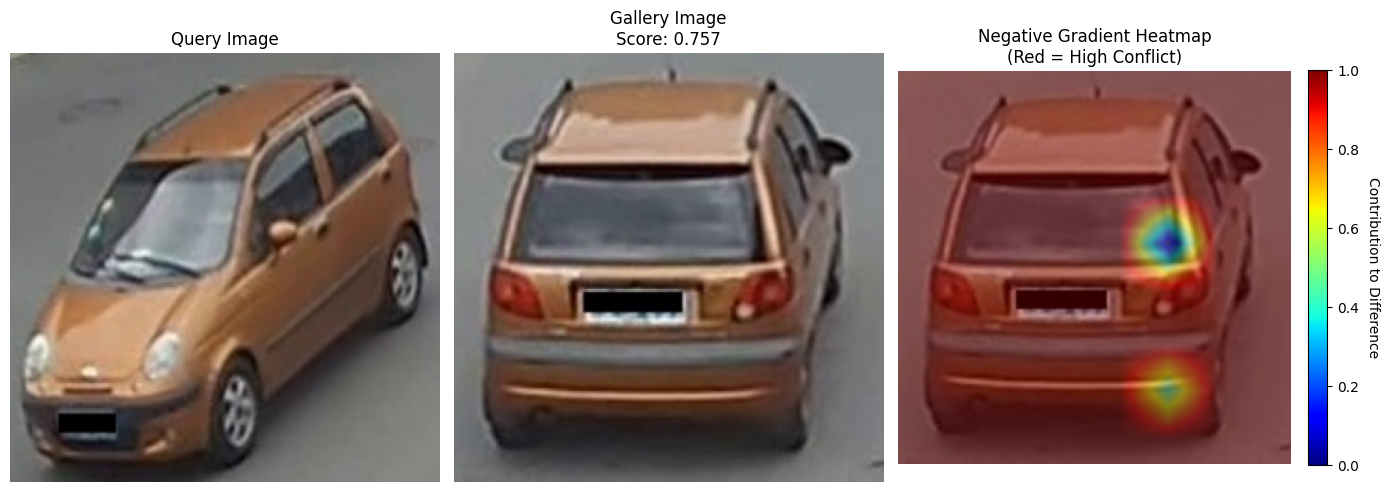

In [37]:
class SimilarityGradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        self.target_layer.register_full_backward_hook(self.save_gradient)
        self.target_layer.register_forward_hook(self.save_activation)

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def save_activation(self, module, input, output):
        self.activations = output

    def __call__(self, query_tensor, gallery_tensor, mode='difference'):
        self.model.zero_grad()
        
        # Forward Pass
        feat_g, _ = self.model(gallery_tensor, torch.zeros(1).long().to(cfg.device))
        with torch.no_grad():
            feat_q, _ = self.model(query_tensor, torch.zeros(1).long().to(cfg.device))

        # Cosine Similarity
        score = torch.sum(F.normalize(feat_q, p=2, dim=1) * F.normalize(feat_g, p=2, dim=1))
        
        # Backward Pass
        score.backward()
        
        # Generate Map
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        if mode == 'difference':
            weights = -weights # Look for negative gradients
        
        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
        cam = F.relu(cam) # ReLU
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-7) # Normalize 0-1
        
        return cam.squeeze().detach().cpu().numpy(), score.item()

# --- 2. VISUALIZATION FUNCTION (Updated with Colorbar) ---
def visualize_difference(model, query_path, gallery_path):
    """This function visualizes the difference heatmap between query and gallery images using Similarity Grad-CAM."""

    img_q_pil = Image.open(query_path).convert('RGB').resize((256, 256))
    img_g_pil = Image.open(gallery_path).convert('RGB').resize((256, 256))
    
    t_q = inference_transforms(img_q_pil).unsqueeze(0).to(cfg.device)
    t_g = inference_transforms(img_g_pil).unsqueeze(0).to(cfg.device)
    
    # Initialize Hook
    model.eval() 
    for param in model.parameters(): param.requires_grad = True
    
    
    grad_cam = SimilarityGradCAM(model, model.backbone.model.layer4)
    
    
    heatmap, score = grad_cam(t_q, t_g, mode='difference')
    
    # Create Overlay
    heatmap_resized = cv2.resize(heatmap, (256, 256))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    img_g_np = np.array(img_g_pil)
    overlay = cv2.addWeighted(img_g_np, 0.6, heatmap_color, 0.4, 0)
    
    # --- PLOTTING ---
    fig, axes = plt.subplots(1, 3, figsize=(14, 5))
    
    # Plot 1: Query
    axes[0].imshow(img_q_pil)
    axes[0].set_title("Query Image")
    axes[0].axis('off')
    
    # Plot 2: Gallery
    axes[1].imshow(img_g_pil)
    axes[1].set_title(f"Gallery Image\nScore: {score:.3f}")
    axes[1].axis('off')
    
    # Plot 3: Difference Overlay
    im = axes[2].imshow(overlay)
    axes[2].set_title("Negative Gradient Heatmap\n(Red = High Conflict)")
    axes[2].axis('off')
    
    # --- ADD COLORBAR ---
    # We create a "ScalarMappable" that matches the 'jet' colormap used in cv2
    sm = cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([]) # Dummy array for matplotlib requirements
    
    # Attach colorbar to the 3rd axis
    cbar = plt.colorbar(sm, ax=axes[2], fraction=0.046, pad=0.04)
    cbar.set_label('Contribution to Difference', rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.show()

# --- EXECUTE ---
if __name__ == "__main__":
    # Define paths
    q_path = "/home/moonlab/Reid/data/VeRi/image_query/0005_c004_00077625_0.jpg"
    g_path = "/home/moonlab/Reid/data/VeRi/image_test/0005_c003_00077695_0.jpg" 
    
    model = load_trained_model("latest_model.pth")
    visualize_difference(model, q_path, g_path)

In [27]:
print(model)

CLIP_SENet(
  (backbone): ResNetIBN(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BottleneckIBN(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): IBN(
            (IN): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
            (BN): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1

In [31]:
print(model.parameters)

<bound method Module.parameters of CLIP_SENet(
  (backbone): ResNetIBN(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BottleneckIBN(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): IBN(
            (IN): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
            (BN): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 25

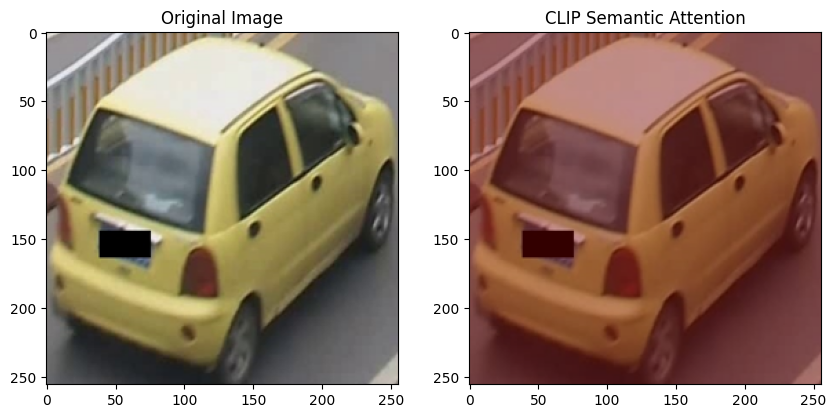

In [36]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T

# --- 1. SPECIALIZED HOOK FOR TRANSFORMERS ---
sem_activations = {}
def get_sem_activation(name):
    def hook(model, input, output):
        # Transformer layers often output a tuple, we want the tensor
        if isinstance(output, tuple):
            sem_activations[name] = output[0].detach()
        else:
            sem_activations[name] = output.detach()
    return hook

# --- 2. VISUALIZATION FUNCTION ---
def visualize_clip_attention(model, image_path):
    # A. Define the Hook Path (Based on your architecture log)
    # CLIP_SENet -> sem_module -> clip -> vision_model -> encoder -> layers -> last one
    target_layer = model.sem_module.clip.vision_model.encoder.layers[-1].layer_norm1
    
    # B. Register Hook
    hook_handle = target_layer.register_forward_hook(get_sem_activation('clip_last_layer'))

    # C. Prepare Image (Standard Resize + Normalize)
    img_pil = Image.open(image_path).convert('RGB')
    transform = T.Compose([
        T.Resize(cfg.image_size), # Ensure this matches your config (e.g. 256x256)
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img_pil).unsqueeze(0).to(cfg.device)
    
    # D. Forward Pass
    model.eval()
    with torch.no_grad():
        # Pass dummy label just to satisfy the forward signature
        model(img_tensor, torch.zeros(1).long().to(cfg.device))
    
    # E. Process the Activation
    # Shape is usually [Batch, N_Tokens, Channels] -> e.g., [1, 50, 768]
    features = sem_activations['clip_last_layer']
    
    # 1. Remove CLS Token (Index 0 is the class token, usually)
    # The remaining tokens correspond to image patches
    patch_tokens = features[:, 1:, :] 
    
    # 2. Reshape to Grid
    # We need to calculate the grid size (e.g. sqrt(49) = 7x7)
    num_patches = patch_tokens.shape[1]
    grid_size = int(np.sqrt(num_patches))
    
    # [1, 49, 768] -> [1, 7, 7, 768] -> Permute to [1, 768, 7, 7]
    feature_map = patch_tokens.view(1, grid_size, grid_size, -1).permute(0, 3, 1, 2)
    
    # 3. Create Heatmap (Mean across channels)
    heatmap = torch.mean(feature_map, dim=1).squeeze().cpu().numpy()
    
    # 4. Normalize & Resize
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (heatmap.max() + 1e-8)
    heatmap = cv2.resize(heatmap, (256, 256)) # Resize to original image size
    
    # F. Visualization
    img_np = np.array(img_pil.resize((256, 256)))
    heatmap_uint8 = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap_color, 0.4, 0)
    
    hook_handle.remove() # Clean up
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1); plt.imshow(img_np); plt.title("Original Image")
    plt.subplot(1, 2, 2); plt.imshow(overlay); plt.title("CLIP Semantic Attention")
    plt.show()

# --- EXECUTE ---
q_path = "/home/moonlab/Reid/data/VeRi/image_query/0002_c002_00030600_0.jpg"
visualize_clip_attention(model, q_path)